GPU上での高速な物理シミュレーションは、(RLHFやOffline RLに押され気味とはいえ)強化学習界隈では話題のトピックですよね。また単純に、GPU上で爆速でシミュレーションが終わるのはなかなか楽しいものです。
[NVIDIA IsaacSym](https://docs.omniverse.nvidia.com/index.html)もありますが、jaxで強化学習パイプライン全体を高速化したいなら[brax](https://github.com/google/brax)が便利です。以前[紹介するブログ](https://kngwyu.github.io/rlog2/posts/jax-brax-haiku.html)も書きましたが、現在のバージョンではより精度のいい手法が選べるようになっていて、普通にMuJoCoの代わりに使えそうな感じです。しかし、最近単純な2次元物理シミュレーションでbraxが使えないかな？と思って検討してみたところ、無理ではないのだけれどどうにも使いづらいな...という印象でした。また、二次元物理シミュレーションをするのに、三次元のボールとかで当たり判定を行うのはちょっと計算資源がもったいない気もします。なら自分で作ってしまえばいいんじゃないか？ということでやってみました。

# 2次元ゲーム物理？

このブログ記事では、いわゆる「2次元ゲーム物理」の代表格として、[Box2D](https://en.wikipedia.org/wiki/Box2D)や[Chipmunk](tps://github.com/slembcke/Chipmunk2D)で実装されている比較的簡素なインパルスベースのシミュレーションを実装してみます。これは、物体が衝突した後の速度・位置の解決を、「衝突した位置から適当なインパルスを与える」ことで解く手法になります。braxでは

> Spring provides fast and cheap simulation for rapid experimentation, using simple impulse-based methods often found in video games.

と説明されています。関節が多い場合などは別の手法の方が精度が上がりますが、単純な2次元物理シミュレーションならこれで十分でしょう。

## Semi-implicit Eulerで物体を動かす

とりあえず、衝突のことはいったん忘れて、物体を動かしてみましょう。物体の位置・速度を$x, v$、その時間微分を$\dot{x} = \frac{dx}{dt}, \dot{v} = \frac{dv}{dt}$とおきます。ニュートンの運動の第二法則から、$F(t) = m \frac{d^2 x}{dt^2}(t)$ですから、最も単純な速度・位置更新の近似は、適当な十分短い時間間隔$\Delta t$をとって、

$$
\dot{x}_{t + 1} = \dot{v}_t \Delta t \\
\dot{v}_{t + 1} = \frac{F}{m} \Delta t
$$

と表せます（Explicit Euler)。これは不安定になるので、今回は安定しやすい[Semi-implicit Euler](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method)を使います。これはアルゴリズム上はすごく単純で、

$$
\dot{v}_{t + 1} = \frac{F}{m} \Delta t \\
\dot{x}_{t + 1} = \dot{v}_{t + 1} \Delta t
$$

とすればいいです。


まず`Velocity`など、必要なものを適当に定義しておきます。剛体ですが、とりあえずこの世界には丸いものしかないことにして、`Circle`だけ定義しましょう。

In [115]:
import functools
from typing import Any, Callable, Sequence

import chex
import jax
import jax.numpy as jnp

Self = Any


class PyTreeOps:
    def __add__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x + y, self, o)
        else:
            return jax.tree_map(lambda x: x + o, self)

    def __sub__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x - y, self, o)
        else:
            return jax.tree_map(lambda x: x - o, self)

    def __mul__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x * o, self)

    def __neg__(self) -> Self:
        return jax.tree_map(lambda x: -x, self)

    def __truediv__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x / o, self)

    def reshape(self, shape: Sequence[int]) -> Self:
        return jax.tree_map(lambda x: x.reshape(shape), self)

    def tolist(self) -> list[Self]:
        leaves, treedef = jax.tree_util.tree_flatten(self)
        return [treedef.unflatten(leaf) for leaf in zip(*leaves)]

    def zeros_like(self) -> Any:
        return jax.tree_map(lambda x: jnp.zeros_like(x), self)


TWO_PI = jnp.pi * 2


@chex.dataclass
class Velocity(PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Force(PyTreeOps):
    angle: jax.Array  # Angular (torque) force (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Position(PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Circle(PyTreeOps):
    mass: jax.Array
    moment: jax.Array
    radius: jax.Array
    rgba: jax.Array


@chex.dataclass
class State(PyTreeOps):
    p: Position
    v: Velocity
    f: Force
    bias_v: Velocity


@chex.dataclass
class Space:
    dt: jax.Array | float
    damping: jax.Array | float
    gravity: jax.Array
    circle: Circle

    @property
    def mass(self) -> jax.Array:
        return self.circle.mass.reshape(-1, 1)
    
    @property
    def moment(self) -> jax.Array:
        return self.circle.moment

次は描画用の関数を準備しましょう。

In [116]:
from typing import Iterable

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from matplotlib.patches import Circle as CirclePatch


def visualize_balls(ax: Axes, circles: Circle, positions: Iterable[Position]) -> None:
    pos = list(positions)
    circle_list = circles.tolist()
    for pi in pos:
        for pij, circle in zip(pi.tolist(), circle_list):
            circle_patch = CirclePatch(
                xy=pij.xy,
                radius=circle.radius,
                fill=False,
                color=circle.rgba.tolist(),
            )
            ax.add_patch(circle_patch)

Semi-implicit Eulerを実装します。

In [121]:
def update_velocity(space: Space, state: State) -> Velocity:
    damped = state.v * space.damping
    v_xy = damped.xy + (space.gravity + state.f.xy / space.mass) * space.dt
    v_ang = damped.angle + state.f.angle / space.moment * space.dt
    return Velocity(angle=v_ang, xy=v_xy)


def semi_implicit_euler(space: Space, state: State) -> State:
    v = update_velocity(space, state)
    v_dt = (v + state.bias_v) * space.dt
    xy = state.p.xy + v_dt.xy
    angle = (state.p.angle + v_dt.angle + TWO_PI) % TWO_PI
    return State(
        p=Position(angle=angle, xy=xy),
        f=state.f.zeros_like(),
        v=v,
        bias_v=v.zeros_like(),
    )

とりあえずボールを落としてみましょう。

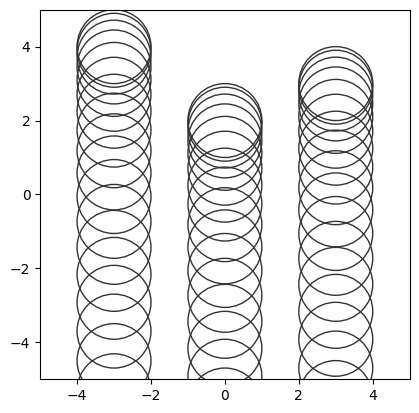

In [122]:
circles = Circle(
    mass=jnp.ones(3),
    radius=jnp.ones(3),
    moment=jnp.ones(3) * 0.5,
    rgba=jnp.tile(jnp.array([0.2, 0.2, 0.2, 1.0]), (3, 1)),
)
space = Space(dt=0.1, damping=0.9, gravity=jnp.array([0.0, -9.8]), circle=circles)
p = Position(
    angle=jnp.array([-2, 0.1, 0.2]),
    xy=jnp.array([[-3, 4.0], [0.0, 2.0], [3.0, 3]]),
)
v = Velocity(angle=jnp.zeros(3), xy=jnp.zeros((3, 2)))
f = Force(angle=jnp.zeros(3), xy=jnp.zeros((3, 2)))
state = State(p=p, v=v, f=f, bias_v=v.zeros_like())
positions = [state.p]
for i in range(20):
    state = semi_implicit_euler(space, state)
    positions.append(state.p)
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
visualize_balls(ax, space.circle, positions)

できたっぽいですね。

## 衝突判定を行う

次に衝突判定を実装してみましょう。円と円なので簡単ですね。